In [1]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def custom_load_vcf( file_path ):
    vcf_file = pysam.VariantFile(file_path, mode='r')
    samples = list(vcf_file.header.samples)
    results = {'chrom': [], 'start': [], 'stop': [], 'id': []}
    for record in vcf_file.fetch():
        results['chrom'].append(record.chrom)
        results['start'].append(record.start)
        results['stop'].append(record.stop)
        results['id'].append(record.id)
    sv_matrix = pd.DataFrame(results)
    vcf_file.close()
    return sv_matrix


cgp4.vcf:
  Number of rows: 2416
  Mean of lenghts: 2.40e+06
  Variance of lenghts: 8.81e+12
cnvpytor_1000.vcf:
  Number of rows: 10379
  Mean of lenghts: 7.73e+04
  Variance of lenghts: 1.07e+09
delly.vcf:
  Number of rows: 13
  Mean of lenghts: 2.61e+04
  Variance of lenghts: 8.14e+09


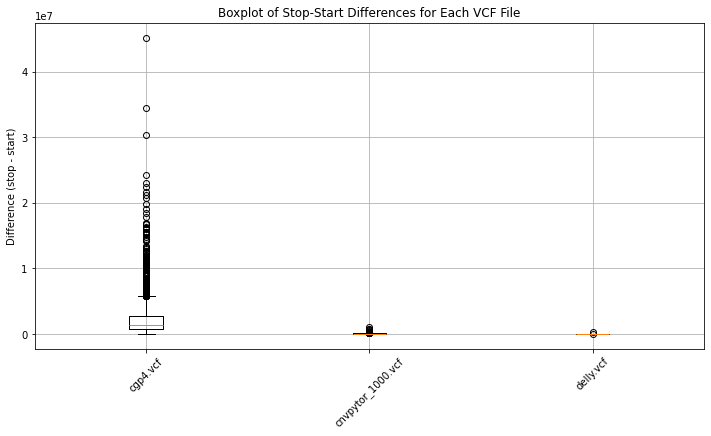

In [3]:
folder_path = 'output/'
filename_list = ['cgp4.vcf', 'cnvpytor_1000.vcf', 'delly.vcf']

loaded_files = {}
row_counts = {}
diff_stats = {}

for filename in filename_list:
    file_path = folder_path + filename
    sv_matrix = custom_load_vcf(file_path)
    
    # Calculate the difference between stop and start
    sv_matrix['diff'] = sv_matrix['stop'] - sv_matrix['start']
    
    # Calculate mean and variance
    mean_diff = sv_matrix['diff'].mean()
    variance_diff = sv_matrix['diff'].var()
    
    # Store results
    loaded_files[filename] = sv_matrix
    row_counts[filename] = len(sv_matrix)
    diff_stats[filename] = {'mean': mean_diff, 'variance': variance_diff}
    
    # Print results
    print(f'{filename}:')
    print(f'  Number of rows: {row_counts[filename]}')
    print(f'  Mean of lenghts: {mean_diff:.2e}')
    print(f'  Variance of lenghts: {variance_diff:.2e}')

# Generate boxplots
plt.figure(figsize=(12, 6))

for filename, sv_matrix in loaded_files.items():
    plt.boxplot(sv_matrix['diff'], positions=[list(loaded_files.keys()).index(filename)], labels=[filename])

plt.title('Boxplot of Stop-Start Differences for Each VCF File')
plt.ylabel('Difference (stop - start)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [4]:
def find_rows_with_stop_before_start(sv_matrix):
    sv_matrix_sorted = sv_matrix.sort_values(by=['chrom', 'start']).reset_index(drop=True)
    invalid_rows = []

    for i in range(1, len(sv_matrix_sorted)):
        if (sv_matrix_sorted.iloc[i]['chrom'] == sv_matrix_sorted.iloc[i - 1]['chrom'] and
            sv_matrix_sorted.iloc[i]['start'] < sv_matrix_sorted.iloc[i - 1]['stop']):
            invalid_rows.append(i-1)
            invalid_rows.append(i)

    return sv_matrix_sorted.iloc[invalid_rows]

for filename, sv_matrix in loaded_files.items():

    invalid_rows = find_rows_with_stop_before_start(sv_matrix)
    
    if not invalid_rows.empty:
        print(f'Invalid rows in {filename}:')
        print(invalid_rows)
    else:
        print(f'No invalid rows in {filename}')

Invalid rows in cgp4.vcf:
     chrom     start      stop               id      diff
2     chr1   3853000   6272000  cgp4_chr1_DUP_2   2419000
3     chr1   4102000   4578000  cgp4_chr1_DEL_0    476000
5     chr1   5675000   7113000  cgp4_chr1_DEL_2   1438000
6     chr1   6273000   6674000  cgp4_chr1_DUP_3    401000
7     chr1   6675000   7813000  cgp4_chr1_DUP_4   1138000
...    ...       ...       ...              ...       ...
2405  chrY   6566000   7145000  cgp4_chrY_DEL_5    579000
2408  chrY  10465000  13827000  cgp4_chrY_DEL_8   3362000
2409  chrY  11815000  57010000  cgp4_chrY_DUP_2  45195000
2409  chrY  11815000  57010000  cgp4_chrY_DUP_2  45195000
2410  chrY  13828000  14687000  cgp4_chrY_DEL_9    859000

[1734 rows x 5 columns]
No invalid rows in cnvpytor_1000.vcf
No invalid rows in delly.vcf


In [5]:
def remove_overlapping_rows(df):
    # Sort the DataFrame by the 'start' column
    df_sorted = df.sort_values(by='start')

    # Initialize an empty list to store non-overlapping rows
    non_overlapping_rows = []

    # Iterate through the sorted DataFrame
    for index, row in df_sorted.iterrows():
        # If the list of non-overlapping rows is empty or if the current row does not overlap with the last row in the list
        if len(non_overlapping_rows) == 0 or row['start'] > non_overlapping_rows[-1]['stop']:
            # Append the current row to the list of non-overlapping rows
            non_overlapping_rows.append(row)
        else:
            # If the current row overlaps with the last row in the list, merge them by updating the stop position of the last row
            non_overlapping_rows[-1]['stop'] = max(non_overlapping_rows[-1]['stop'], row['stop'])

    # Convert the list of non-overlapping rows back to a DataFrame
    non_overlapping_df = pd.DataFrame(non_overlapping_rows)

    return non_overlapping_df

cgp4_non_overlapping = remove_overlapping_rows(loaded_files[filename_list[0]])

invalid_rows = find_rows_with_stop_before_start(cgp4_non_overlapping)
if not invalid_rows.empty:
    print(f'Invalid rows in cgp4_non_overlapping:')
    print(invalid_rows)
else:
    print(f'No invalid rows in cgp4_non_overlapping')


No invalid rows in cgp4_non_overlapping


In [6]:
loaded_files_non_overlapping = loaded_files
loaded_files_non_overlapping['cgp4.vcf'] = cgp4_non_overlapping

In [7]:
def calculate_common_intersection_area(df1, df2):
    
    # Group DataFrames by chromosome
    grouped_df1 = df1.groupby('chrom')
    grouped_df2 = df2.groupby('chrom')
    
    total_common_intersection_area = 0
    total_common_union_area = 0
    
    # Calculate common intersection area for each chromosome
    for chrom, data1 in grouped_df1:
        if chrom in grouped_df2.groups:
            data2 = grouped_df2.get_group(chrom)
            total_common_intersection_area += calculate_intersection_area_between_two(data1, data2)
            total_common_union_area += calculate_union_area_between_two(data1, data2)
    
    return total_common_intersection_area, total_common_union_area

def calculate_union_area_between_two(data1, data2):
    # Combine data1 and data2
    combined_df = pd.concat([data1, data2])
    
    # Remove overlapping rows
    non_overlapping_df = remove_overlapping_rows(combined_df)
    
    # Calculate union area
    union_area = sum(non_overlapping_df['stop'] - non_overlapping_df['start'])
    
    return union_area

def calculate_intersection_area_between_two(data1, data2):
    total_intersection_area = 0
    total_union_area = 0
    sorted_data1 = data1.sort_values(by=['start'])
    sorted_data2 = data2.sort_values(by=['start'])
    index1 = 0
    index2 = 0
    
    while index1 < len(sorted_data1) and index2 < len(sorted_data2):
        row1 = sorted_data1.iloc[index1]
        row2 = sorted_data2.iloc[index2]
        
        start1 = row1['start']
        stop1 = row1['stop']
        start2 = row2['start']
        stop2 = row2['stop']
        
        # Calculate intersection
        intersection_start = max(start1, start2)
        intersection_end = min(stop1, stop2)
        
        if intersection_end > intersection_start:
            total_intersection_area += intersection_end - intersection_start
        
        # Move to the next region with the smallest stop coordinate
        if stop1 < stop2:
            index1 += 1
        else:
            index2 += 1
    
    return total_intersection_area

# Example usage with file paths
file1 = loaded_files[filename_list[1]]
file2 = loaded_files[filename_list[2]]

common_intersection_area, common_union_area = calculate_common_intersection_area(file1, file2)
print("Common Intersection Area:", common_intersection_area)
print("Common Union Area:", common_union_area)

Common Intersection Area: 84000
Common Union Area: 395806528


In [8]:
for filename, sv_matrix in loaded_files.items():

    invalid_rows = find_rows_with_stop_before_start(sv_matrix)
    
    if not invalid_rows.empty:
        print(f'Invalid rows in {filename}:')
        print(invalid_rows)
    else:
        print(f'No invalid rows in {filename}')

No invalid rows in cgp4.vcf
No invalid rows in cnvpytor_1000.vcf
No invalid rows in delly.vcf


In [9]:
for i in range(len(loaded_files)):
    for j in range(i+1, len(loaded_files)):
        name1 = filename_list[i]
        name2 = filename_list[j]
        df1, df2 = loaded_files[name1], loaded_files[name2]
        common_intersection_area, common_union_area = calculate_common_intersection_area(df1, df2)
        if common_union_area > 0:
            iou = common_intersection_area / common_union_area
        else:
            iou = 0.0
        print(f"IoU for {name1} and {name2}:  {iou*100:.4}%")

IoU for cgp4.vcf and cnvpytor_1000.vcf:  6.879%
IoU for cgp4.vcf and delly.vcf:  0.0%
IoU for cnvpytor_1000.vcf and delly.vcf:  0.02122%
